# Physics-Informed Neural Networks (PINNs) with PyTorch

In this notebook, we implement a Physics-Informed Neural Network (PINN) to solve a simple ordinary differential equation (ODE):

$$
u''(x) + \pi^2 u(x) = 0
$$

with boundary conditions:

$$
u(0)=0 \quad \text{and} \quad u(1)=0.
$$

The well-known non-trivial solution to this problem is $ u(x) = \sin(\pi x) $. However, note that the trivial solution $ u(x)=0 $ also satisfies these conditions. To ensure the network learns the sine solution, we add an interior data point $ u(0.5)=1 $ as an extra constraint.

This notebook walks through building the network, enforcing the PDE with automatic differentiation, setting up the loss function, training the model, and finally evaluating the result.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

## Defining the PINN Neural Network Architecture

We define a custom neural network class `PINN` which inherits from `nn.Module`. This network:
- Uses a feedforward architecture.
- Applies the hyperbolic tangent (Tanh) activation function in the hidden layers.
- Has a configurable number of layers based on the provided `layers` list.

The architecture is defined by the list `layers = [1, 20, 20, 20, 1]`, meaning:
- One input neuron (for $ x $).
- Three hidden layers with 20 neurons each.
- One output neuron (for $ u(x) $).

In [2]:
# Define the neural network architecture for the PINN
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.activation = nn.Tanh()  # Using Tanh for smooth, non-linear activation
        layer_list = []
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
        self.layers = nn.ModuleList(layer_list)

    def forward(self, x):
        # Pass input through all layers with activation (except final layer)
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

# Create an instance of the network with defined architecture: 1 input, 3 hidden layers with 20 neurons, 1 output
layers = [1, 20, 20, 20, 1]
model = PINN(layers)

## Defining the PDE Residual Function

To incorporate the physics into our network, we need to ensure the predicted solution satisfies the differential equation. We achieve this by:
- Using PyTorch's automatic differentiation (`torch.autograd.grad`) to compute the first and second derivatives of the network's output $ u(x) $ with respect to $ x $.
- Computing the residual of the ODE:
  
  $$
  \text{residual} = u''(x) + \pi^2 u(x)
  $$

The goal is to minimize this residual so that the network's prediction conforms to the ODE.

In [3]:
# Function to compute the PDE residual: u''(x) + pi^2 * u(x) = 0
def pde_residual(model, x):
    # Ensure x has gradients for auto-differentiation
    x = x.clone().detach().requires_grad_(True)
    u = model(x)

    # Compute the first derivative du/dx
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Compute the second derivative d^2u/dx^2
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    # Calculate the residual of the PDE
    residual = u_xx + (torch.pi**2) * u
    return residual

## Setting Up Training Components

### Optimizer and Training Parameters
We use the Adam optimizer with a learning rate of $1e{-3}$ and set the number of training epochs to 5000.

### Defining the Domain and Data Points
- **Collocation Points (`x_collocation`)**: 100 evenly spaced points in $[0,1]$ where we enforce the PDE residual.
- **Boundary Points (`x_boundary`)**: Points at $ x=0 $ and $ x=1 $ with the known boundary conditions $ u(0)=0 $ and $ u(1)=0 $.
- **Interior Data Point (`x_interior`)**: An additional point at $ x=0.5 $ where we force $ u(0.5)=1 $ to steer the network away from the trivial zero solution.

In [4]:
# Set up the optimizer and training parameters
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 5000

# Define collocation points inside the domain for enforcing the PDE residual
x_collocation = torch.linspace(0, 1, 100).view(-1, 1)

# Define boundary points and their known values: u(0)=0 and u(1)=0
x_boundary = torch.tensor([[0.0], [1.0]], dtype=torch.float32)
u_boundary = torch.zeros_like(x_boundary)

# Define an interior data point to enforce the non-trivial solution: for example, u(0.5)=1.0
x_interior = torch.tensor([[0.5]], dtype=torch.float32)
u_interior = torch.tensor([[1.0]], dtype=torch.float32)

## Training the PINN

In the training loop, we perform the following steps:
1. **Zero the gradients** at the beginning of each epoch.
2. **Compute the physics loss** by evaluating the PDE residual at the collocation points and taking the mean squared error.
3. **Compute the boundary loss** by comparing the network's prediction at the boundary points with the known boundary values.
4. **Compute the interior loss** by enforcing the condition $ u(0.5)=1 $.
5. **Combine all loss components** to form the total loss.
6. **Backpropagate** the total loss and update the model parameters using the optimizer.
7. **Print training progress** every 500 epochs.

The following cell implements the training process.

In [5]:
# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Compute physics loss on collocation points (how well the PDE is satisfied)
    res = pde_residual(model, x_collocation)
    loss_physics = torch.mean(res**2)

    # Compute boundary loss (enforcing u(0)=0 and u(1)=0)
    u_pred_boundary = model(x_boundary)
    loss_boundary = torch.mean((u_pred_boundary - u_boundary)**2)

    # Compute interior loss (forcing u(0.5)=1)
    u_pred_interior = model(x_interior)
    loss_interior = torch.mean((u_pred_interior - u_interior)**2)

    # Total loss: sum of physics, boundary, and interior data losses
    loss = loss_physics + loss_boundary + loss_interior
    loss.backward()
    optimizer.step()

    # Print training progress every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.6f}")

print("Training complete!")

Epoch 0: Total Loss = 1.724636
Epoch 500: Total Loss = 0.003156
Epoch 1000: Total Loss = 0.000874
Epoch 1500: Total Loss = 0.000411
Epoch 2000: Total Loss = 0.000260
Epoch 2500: Total Loss = 0.001062
Epoch 3000: Total Loss = 0.000055
Epoch 3500: Total Loss = 0.000039
Epoch 4000: Total Loss = 0.004162
Epoch 4500: Total Loss = 0.000020
Training complete!


## Evaluating and Visualizing the Result

After training, we evaluate the trained model over the domain $[0, 1]$. We:
- Generate test points.
- Compute the network's predictions.
- Compute the analytical solution $ u(x)=\sin(\pi x) $ for comparison.
- Plot both the PINN prediction and the analytical solution using Matplotlib.

This visual comparison helps us see how closely the network approximates the true solution.

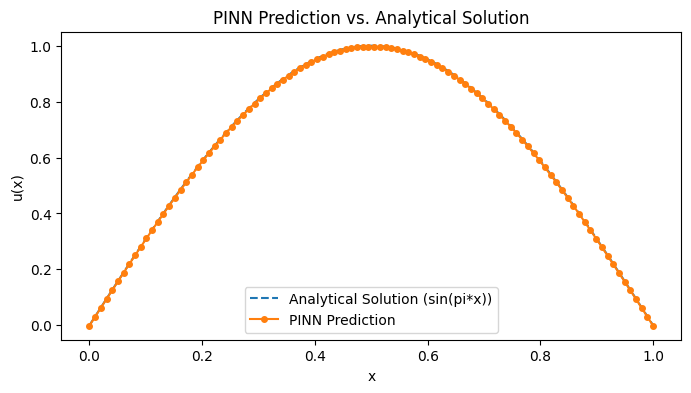

In [6]:
# Evaluate the trained model over the domain [0, 1]
x_test = torch.linspace(0, 1, 100).view(-1, 1)
with torch.no_grad():
    u_pred = model(x_test).numpy().flatten()

# Compute the analytical solution for comparison: u(x) = sin(pi * x)
x_np = x_test.numpy().flatten()
u_true = np.sin(np.pi * x_np)

# Plot the PINN prediction vs. the analytical solution
plt.figure(figsize=(8, 4))
plt.plot(x_np, u_true, label='Analytical Solution (sin(pi*x))', linestyle='dashed')
plt.plot(x_np, u_pred, label='PINN Prediction', marker='o', markersize=4)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.title('PINN Prediction vs. Analytical Solution')
plt.show()

## Conclusion

In this notebook, we built a Physics-Informed Neural Network (PINN) with PyTorch to solve the ODE:

$$
u''(x) + \pi^2 u(x) = 0,
$$

with boundary conditions $ u(0)=0 $ and $ u(1)=0 $. To ensure the network learns the desired non-trivial solution $ u(x)=\sin(\pi x) $ instead of the trivial zero solution, we added an interior data point $ u(0.5)=1 $.

The notebook demonstrated:
- How to construct a simple feedforward network.
- How to enforce physics using automatic differentiation.
- How to define a loss function that combines physics, boundary, and interior data losses.
- The training process and visualization of the network's prediction versus the analytical solution.

This detailed explanation should help you understand how PINNs blend deep learning with physical laws to solve differential equations, even when data is limited.